<a href="https://colab.research.google.com/github/Kira8045/ColorizedMNIST_GAN/blob/master/ColorizedMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
tf.get_logger().setLevel('WARNING')

In [3]:
import tensorflow as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image as img
from IPython.display import clear_output, Image
from tensorflow.examples.tutorials.mnist import input_data
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU,Dropout
from keras.optimizers import Adam, RMSprop
from keras.layers import BatchNormalization

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [4]:
x_train = input_data.read_data_sets( "mnist",one_hot = True ).train.images
x_train = x_train.reshape((-1,28,28,1)).astype(np.float32)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


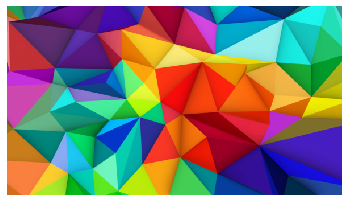

In [5]:
ref_image = img.open("/content/drive/My Drive/Colab Notebooks/mnist_colorized_GAN/Low Poly Colorful Background Preview.jpg")
plt.imshow(ref_image)
plt.axis("off")
plt.show()

In [0]:
import scipy.ndimage

def get_mnist_batch_sample(batch_size = 256, change_colors = False):
  idx = np.random.choice(x_train.shape[0], batch_size)
  batch_raw = x_train[idx,:,:,0].reshape((batch_size,28,28,1))

  batch_resized = np.asarray([ scipy.ndimage.zoom( image, (2.3,2.3,1), order = 1 ) for image in batch_raw ])
  batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis = 3)
  batch_binary = (batch_rgb > 0.5)
  batch = np.zeros((batch_size, 64,64,3))
  for i in range(batch_size):
    x_c = np.random.randint( 0, ref_image.size[0]-64 )
    y_c = np.random.randint( 0, ref_image.size[1]-64 )
    image = ref_image.crop( (x_c,y_c, x_c+64,  y_c+64) )
    image = (np.array(image))/255.0
    if change_colors : 
      for j in range(3):
        image[:,:,j] = image[:,:,j] + np.random.uniform(0, 1)/2.0
      
    image[batch_binary[i]] = 1- image[batch_binary[i]]
    batch[i] = image

  return batch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

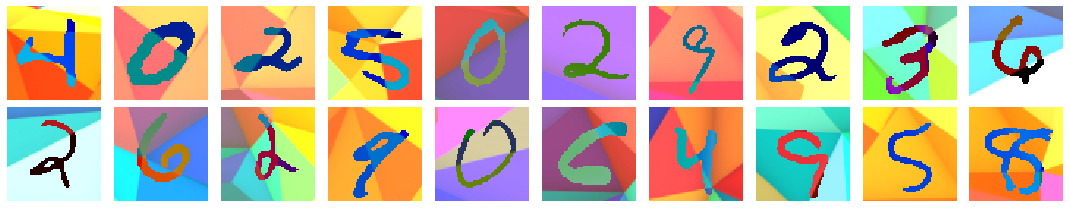

In [7]:
count = 20
examples = get_mnist_batch_sample(count, True)
plt.figure(figsize = (15,3) )
for i in range(count):
  plt.subplot( 2, count//2 , i+1 )
  plt.imshow(examples[i])
  plt.axis("off")
  
plt.tight_layout()
plt.show()

In [0]:
def create_discriminator():
  net = Sequential()
  input_shape = (64,64,3)
  dropout_prob = 0.4

  net.add( Conv2D( 64 , 5 ,strides=2, input_shape = input_shape, padding = "same" ) )
  net.add( LeakyReLU() )

  net.add( Conv2D(128, 5, strides = 2, padding = "same") )
  net.add(LeakyReLU())
  net.add(Dropout(dropout_prob))

  net.add( Conv2D( 256, 5, strides = 2, padding = "same" ) )
  net.add(LeakyReLU())
  net.add(Dropout(dropout_prob))
  
  net.add( Conv2D( 512, 5, strides = 2, padding = "same" ) )
  net.add(LeakyReLU())
  net.add(Dropout(dropout_prob))

  net.add(Flatten())
  net.add(Dense(1))  
  net.add(Activation("sigmoid"))

  return net

In [9]:
net_discriminator = create_discriminator()
net_discriminator.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
_

In [0]:
def create_generator():
  net = Sequential()
  dropout_prob = 0.4

  net.add( Dense( 8*8*256, input_dim = 100 ) )
  net.add(BatchNormalization( momentum= 0.9 ))
  net.add( Activation("relu") )
  net.add(Reshape((8,8,256)))
  net.add(Dropout(dropout_prob))

  net.add( UpSampling2D() )
  net.add(Conv2D( 128, 5, padding = "same" ))
  net.add(BatchNormalization(momentum= 0.9))
  net.add(Activation("relu"))

  net.add( UpSampling2D() )
  net.add(Conv2D( 128, 5, padding = "same" ))
  net.add(BatchNormalization(momentum= 0.9))
  net.add(Activation("relu"))

  net.add(UpSampling2D())
  net.add(Conv2D( 64, 5, padding = "same" ))
  net.add(BatchNormalization(momentum= 0.9))
  net.add(Activation("relu"))

  net.add(Conv2D( 32, 5, padding = "same" ))
  net.add(BatchNormalization(momentum= 0.9))
  net.add(Activation("relu"))

  net.add(Conv2D(3, 5, padding = "same"))
  net.add(Activation("tanh"))

  return net

In [11]:
net_generator = create_generator()
net_generator.summary()









Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
activation_2 (Activation)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 12

In [12]:
optim_discriminator = RMSprop( lr = 0.0002, clipvalue = 1.0, decay= 6e-8 )
model_discriminator = Sequential()
model_discriminator.add( net_discriminator )
model_discriminator.compile( loss = "binary_crossentropy", optimizer = optim_discriminator, metrics = ["accuracy"] )
model_discriminator.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1)                 4314753   
Total params: 4,314,753
Trainable params: 4,314,753
Non-trainable params: 0
_________________________________________________________________


In [13]:
optim_adversarial = Adam( lr = 0.0001, clipvalue = 1.0, decay = 3e-8 )
model_adversarial = Sequential()
model_adversarial.add(net_generator)
for layer in net_discriminator.layers:
  layer.trainable = False
model_adversarial.add(net_discriminator)
model_adversarial.compile( loss = "binary_crossentropy", optimizer = optim_adversarial , metrics = ["accuracy"] )
model_adversarial.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         3209283   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4314753   
Total params: 7,524,036
Trainable params: 3,175,811
Non-trainable params: 4,348,225
_________________________________________________________________


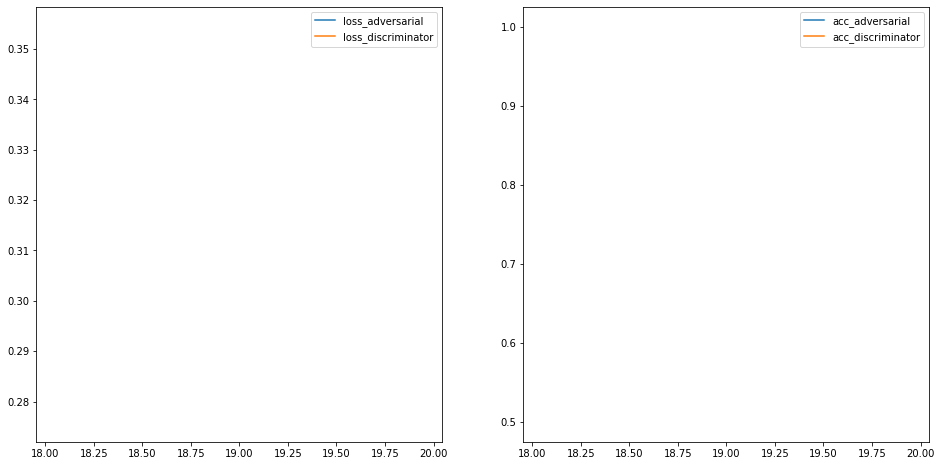

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [0]:
batch_size = 128
epochs = 20000

vis_noise = np.random.uniform(-1,1 , [16,100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

for epoch in range(epochs):
  images_train = get_mnist_batch_sample(batch_size, True)
  noise = np.random.uniform(-1, 1, size = [batch_size, 100])
  images_fake = net_generator.predict(noise)

  x = np.concatenate([images_train, images_fake])
  y = np.ones([2*batch_size, 1])
  y[batch_size:, :] = 0

  model_discriminator.train_on_batch(x ,y)
  d_stats = model_discriminator.train_on_batch(x ,y)

  y = np.ones([batch_size, 1])

  noise = np.random.uniform(-1, 1, [batch_size, 100])
  a_stats = model_adversarial.train_on_batch(noise, y)

  if epoch%50==0:
    plot_iteration.append(i)
    loss_adv.append(a_stats[0])
    loss_dis.append(d_stats[0])
    acc_adv.append(a_stats[1])
    acc_dis.append(d_stats[1])
    
    print(loss_adv)
    clear_output( wait = True )
    fig,(ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,8)
    ax1.plot( plot_iteration, loss_adv, label = "loss_adversarial" )
    ax1.plot( plot_iteration, loss_dis, label = "loss_discriminator" )
    ax1.legend()
    ax2.plot( plot_iteration, acc_adv, label = "acc_adversarial" )
    ax2.plot( plot_iteration, acc_dis, label = "acc_discriminator" )
    ax2.legend()

    plt.show()

  if (epoch < 1000 and epoch%50 == 0) or (epoch % 100 == 0):
        images = net_generator.predict(vis_noise)
        
        # Map back to original range
        #images = (images + 1 ) * 0.5
        
        plt.figure(figsize=(10,10))
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [64,64,3])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(r'/content/drive/My Drive/Colab Notebooks/mnist_colorized_GAN/output/mnist-color/{}.png'.format(epoch))
        plt.close('all')
  

In [0]:
plt.figure(figsize=(15,4))

for i in range(10):
    noise = np.zeros([1,100]) - 1 + (i * 0.2) + 0.1 
    images = net_generator.predict(noise)
    
    image = images[0, :, :, :]
    image = np.reshape(image, [64, 64, 3])
          
    plt.subplot(1, 10, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()